##  주제 :  여행 상품 계약률을 높이기 위한 방안 도출



#### 1. 분석 목적
#### 2.  데이터 준비   
2.1    데이터 컬럼 확인   
2.2    데이터 전처리   

#### 3.       고객 분석 및 방안 도출
3.1    연령별 고객분석    
3.2    소득별 고객분석   
3.3    도시별 고객분석   

#### 4.   영업 데이터 분석 및 방안 도출
4.1    영업사원의 추천 상품 분석     
4.2    그 외 영업관련 데이터 분석     
4.3 영업 데이터 분석 정리 

#### 

In [1]:
from scipy.stats import chi2_contingency
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))
import pandas as pd
import numpy as np
from pandas import Series
import warnings                                                                # 경고 메시지를 무시하고 숨기기 
warnings.filterwarnings('ignore')                                              # import warnings  # warnings.filterwarnings('ignore') 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score  

# 1. 분석 목적

전체 고객 중, 
* 계약 고객 : 18.8% 
* 미계약 고객 : 81.2%

### 비지니스 과제 : 데이터 분석을 통해, 현재 상품 계약률 18.8%에서 계약률을 높이기 위한 방안 도출


# 2.  데이터 준비


In [2]:
# 출처 : kaggle (https://www.kaggle.com/datasets/sanamps/tourpackageprediction)
train = pd.read_csv('/Users/EUNJI/Desktop/dacon/투어패키지/tour_package.csv')
train = train.dropna()

In [3]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

%matplotlib inline
font_path = "/users/eunji/library/fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4128 non-null   int64  
 1   ProdTaken                 4128 non-null   int64  
 2   Age                       4128 non-null   float64
 3   TypeofContact             4128 non-null   object 
 4   CityTier                  4128 non-null   int64  
 5   DurationOfPitch           4128 non-null   float64
 6   Occupation                4128 non-null   object 
 7   Gender                    4128 non-null   object 
 8   NumberOfPersonVisiting    4128 non-null   int64  
 9   NumberOfFollowups         4128 non-null   float64
 10  ProductPitched            4128 non-null   object 
 11  PreferredPropertyStar     4128 non-null   float64
 12  MaritalStatus             4128 non-null   object 
 13  NumberOfTrips             4128 non-null   float64
 14  Passport

## (1) 데이터 컬럼 확인
#### 상품 신청 여부 
ProdTaken : 고객이 여행 패키지 신청 여부 (0: 신청 안 함, 1: 신청함) 

#### 고객 기본 정보 
CustomerID : 고객 아이디   
Age : 나이   
Gender : 성별   
Occupation : 직업   
Designation : (직업의) 직급   
MonthlyIncome : 월 급여                             
OwnCar : 자동차 보유 여부 (0: 없음, 1: 있음)   
CityTier : 주거 중인 도시의 등급. (인구, 시설, 생활 수준 기준) (1등급 > 2등급 > 3등급)   
MaritalStatus : 결혼 여부   
      
#### 여행 관련 정보
Passport : 여권 보유 여부 (0: 없음, 1: 있음)  
NumberOfTrips : 평균 연간 여행 횟수   
NumberOfChildrenVisiting : 고객과 함께 여행을 계획 중인 5세 미만의 어린이 수       
NumberOfPersonVisiting : 고객과 함께 여행을 계획 중인 총 인원  
PreferredPropertyStar : 선호 호텔 숙박업소 등급  (1~5star)  

    
#### 고객 영업 마케팅 관련
TypeofContact : 고객의 제품 인지 방법 (회사의 홍보 or 스스로 검색)  
PitchSatisfactionScore : 영업 사원의 추천 만족도  
DurationOfPitch : 영업 사원의 추천 기간  
NumberOfFollowups : 영업 사원의 프레젠테이션 후 이루어진 후속 조치 수    
ProductPitched : 영업 사원이 추천한 상품** 

#### **기본 가정 : (주어진 데이터에는 고객의 최종 계약 상품에 대한 데이터가 없기 때문에)  
#### 상품 신청 고객은 영업사원에게 추천 받은 상품(Product Pitched)으로 최종 계약했다고 가정하고 분석 진행
  
###  

In [5]:
# train data 피처요약표 함수 : 피처요약표로 데이터들의 대략적인 정보를 얻기 

def resumetable(df):
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫번째 값'] = df.loc[0].values
    summary['두번째 값'] = df.loc[1].values
    summary['세번째 값'] = df.loc[2].values
    summary = summary.sort_values('데이터 타입').reset_index(drop=True)

    return summary

resumetable(train)

,피처,데이터 타입,결측값 개수,고윳값 개수,첫번째 값,두번째 값,세번째 값
0,CustomerID,int64,0,4128,200000,200001,200002
1,ProdTaken,int64,0,2,1,0,1
2,OwnCar,int64,0,2,1,1,0
3,CityTier,int64,0,3,3,1,1
4,PitchSatisfactionScore,int64,0,5,2,3,3
5,Passport,int64,0,2,1,0,1
6,NumberOfPersonVisiting,int64,0,5,3,3,3
7,NumberOfChildrenVisiting,float64,0,4,0.0,2.0,0.0
8,NumberOfTrips,float64,0,12,1.0,2.0,7.0
9,PreferredPropertyStar,float64,0,3,3.0,4.0,3.0


#### 

In [6]:
# 불필요한 CustomerID 칼럼 제거
train = train.drop(['CustomerID'],axis=1)

In [7]:
train.shape

(4128, 19)

In [8]:
# 정확한 분석을 위해 데이터가 누락된 행은 drop
train = train.dropna().reset_index(drop=True)

## (2) 데이터 전처리

In [9]:
# Age 컬럼 범주화 -> Age_category
#  10대 : 1, 20대 : 2, 30대 : 3, 40대 : 4, 50대이상 : 5
train['Age_category'] = train['Age']// 10 
li=[]
for i in train['Age_category']:
    if i>=4 :
        li.append(4)
    else :
        li.append(i)
train['Age_category'] = li
train['Age_category_str']=(train['Age_category']).replace({1:'10대', 2:'20대',3:'30대', 4:'40대이상'})

In [10]:
train['Age_category_str'].value_counts() 

30대      1840
40대이상    1459
20대       787
10대        42
Name: Age_category_str, dtype: int64

#### 10대는 총 46명(전체 인원의 1%)밖에 되지 않기 때문에 분석의 신뢰도가 떨어질 수 있어서 삭제하는 것으로 함

In [11]:
train = train[train['Age_category_str']!='10대']   
train['Age_category_str'] = train['Age_category_str'].astype('category')
train.shape
print('10대 데이터 46개 삭제 완료')

10대 데이터 46개 삭제 완료


In [12]:
# Age 컬럼 범주화 -> Age_category_2  
#  '15~19세' : 0 ,'20~24세' : 1, '25~29세' : 2,'30~34세' : 3,'35세~39세' : 4
#  '40~44세' : 5, '45~49세' : 6, '50~54세' : 7, '55세 이상': 8
train['Age_category_2'] = train['Age']// 5 - 3
li=[]
for i in train['Age_category_2']:
    if i>=8 :
        li.append(8)
    else :
        li.append(i)
train['Age_category_2'] = li

Text(0.5, 0, '연령대')

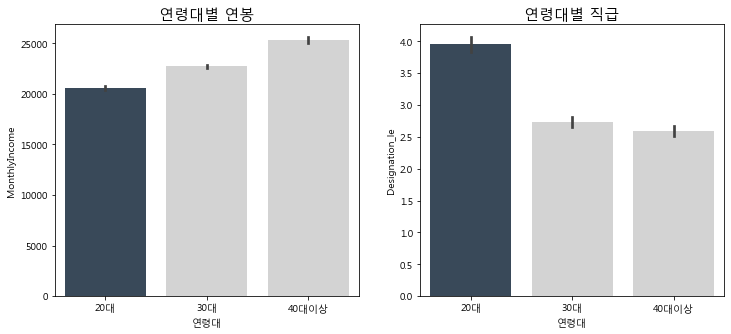

In [13]:
# Designation 직급 -> 직급별로 라벨인코딩

dic={'Manager' : 1, 'Senior Manager':2, 'AVP':3 ,'VP':4, 'Executive':5}
train['Designation_le']=train['Designation'].replace(dic)
palette=['#34495e','lightgrey','lightgrey']
plt.figure(figsize=(12,5))
area1 = plt.subplot(1,2,1)
ax1=sns.barplot(data=train, x='Age_category_str', y='MonthlyIncome', palette=palette, ax=area1, order=['20대','30대','40대이상'])
plt.title('연령대별 연봉', fontsize=15)
plt.xlabel('연령대')

area2 = plt.subplot(1,2,2)
ax2=sns.barplot(data=train, x='Age_category_str', y='Designation_le', palette=palette, ax=area2, order=['20대','30대','40대이상'])
plt.title('연령대별 직급', fontsize=15)
plt.xlabel('연령대')
# * Designation_le : 직급이 높아질수록 숫자가 증가하도록 라벨 인코딩을 하였다.     
#'Manager' : 1, 'Senior Manager':2, 'AVP':3 ,'VP':4, 'Executive':5

* 'Manager' : 1, 'Senior Manager':2, 'AVP':3 ,'VP':4, 'Executive':5
#### *  일반적으로 직급과  급여는 양의 상관관계가 나타나는데, 
####     현 데이터에서는 20대의 평균 직급이 가장 높게 나타나고, 20대의 평균 연봉은 가장 낮게 나타남 (error로 추정)

####    ->   직급 (Designation) 데이터 자체에 오류가 있는 것으로 보여 변수 탈락 결정 


In [14]:
# 직급 컬럼 삭제
train = train.drop(['Designation_le', 'Designation'],1) 

이상치 1개 삭제 완료


Text(0.5, 1.0, '이상치 제거 후')

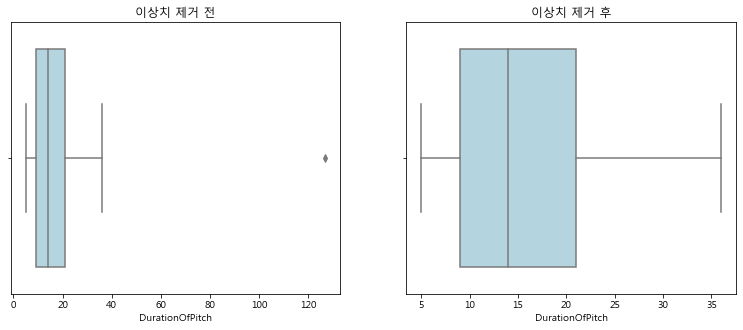

In [15]:
# DurationOfPitch (영업사원이 고객에게 추천한 기간) -> max값은 이상치로 분류해 삭제 

print('이상치 1개 삭제 완료')


plt.figure(figsize=(13,5))
area1 = plt.subplot(1,2,1)
ax1= sns.boxplot(train['DurationOfPitch'], color='lightblue', ax=area1) 
plt.title('이상치 제거 전')

A = train['DurationOfPitch'].describe()['75%'] + (train['DurationOfPitch'].describe()['75%']-train['DurationOfPitch'].describe()['25%'])*1.5
train = train[(train['DurationOfPitch'] <= A)]
area2 = plt.subplot(1,2,2)
ax2= sns.boxplot(train['DurationOfPitch'], color='lightblue', ax=area2) 
plt.title('이상치 제거 후')

In [16]:
# 'DurationOfPitch (영업사원이 고객에게 추천한 기간)  ->  단위 변경 (일 => 1주일 단위로)

# 1주 미만          -> 0
# 1주 이상 2주 미만   -> 1 
# 2주 이상 3주 미만   -> 2
# 3주 이상 4주 미만   -> 3
# 4주 이상 5주 미만   -> 4
# 5주 이상          -> 5


train['DurationOfPitch(주별)'] = train['DurationOfPitch']//7
train['DurationOfPitch(주별)'].unique() 

li=[]
for i in train['DurationOfPitch(주별)'] : 
    if i  <= 5:
        li.append(i)
    else : 
        li.append(5)
train['DurationOfPitch(주별)'] = li

Text(0.5, 1.0, '이상치 제거 후')

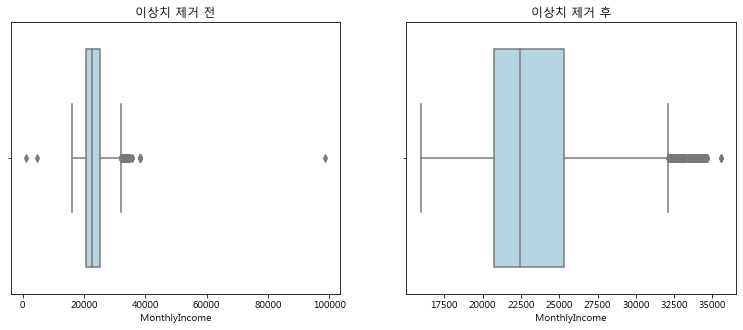

In [17]:
# MonthlyIncome 고객의 월 소득 

plt.figure(figsize=(13,5))
area1 = plt.subplot(1,2,1)
ax1= sns.boxplot(train['MonthlyIncome'], color='lightblue', ax=area1) 
plt.title('이상치 제거 전')

A = round(train['MonthlyIncome'].describe()['25%'] - 
    (train['MonthlyIncome'].describe()['75%']-train['MonthlyIncome'].describe()['25%'])*1.5)

train = train[(train['MonthlyIncome'] >= A)&(train['MonthlyIncome'] <= 38000)]
area2 = plt.subplot(1,2,2)
ax2= sns.boxplot(train['MonthlyIncome'], color='lightblue', ax=area2) 
plt.title('이상치 제거 후')


- 월소득 13951이하, 38000이상을 이상치로 고려하고 삭제     
- 월소득 32000~38000 고객은 초고가 상품(King)에 대한 수요층으로 고려되어 이상치로 고려하지 않음

In [18]:
# MonthlyIncome 고객의 월 소득 -> binning

# 제 1사분위군, 제 2사분위군 -> 1
# 제 3사분위군 -> 2
# 제 4사분위군 -> 3 

B=round(train['MonthlyIncome'].quantile(0.5))
C=round(train['MonthlyIncome'].quantile(0.75))
D=round(train['MonthlyIncome'].quantile(1))

li=[]
a=0
for i in train['MonthlyIncome']:
    if i<=train['MonthlyIncome'].quantile(0.5):
        a=1
        li.append(a)
    elif i<=train['MonthlyIncome'].quantile(0.75):
        a=2
        li.append(a)  
    else :
        a=3
        li.append(a)
        
train['MonthlyIncome_2'] = li
train['MonthlyIncome_2'].value_counts()


1    2037
2    1018
3    1018
Name: MonthlyIncome_2, dtype: int64

In [19]:
train['MonthlyIncome_range'] = train['MonthlyIncome_2'].replace({1:f'{A}~{B}',2:f'{B}~{C}', 3:f'{C}~{D}'} )

In [20]:
train['MonthlyIncome_str'] = train['MonthlyIncome_2'].replace({1:'소득구분1그룹',2:'소득구분2그룹', 3:'소득구분3그룹'} )

In [21]:
# Number Of Children Visiting 컬럼을 활용해, 파생변수 생성 ->  어린이 동반 / 미동반으로 분류한 Children Visiting 변수 추기 

# 동반 : 1, 미동반 :0 
d = {0:'미동반', 1:'동반', 2:'동반', 3:'동반'}
train['ChildrenVisiting'] = train['NumberOfChildrenVisiting'].replace(d)
print(train['ChildrenVisiting'].value_counts())

동반     3240
미동반     833
Name: ChildrenVisiting, dtype: int64


In [22]:
# 고유값 확인을 통해 성별 Fe Male을 Female로 변경해야함을 확인 
for col in train.columns:
    print(f'{col}: {train[col].unique()}')

ProdTaken: [1 0]
Age: [41. 49. 37. 33. 32. 59. 30. 38. 36. 35. 31. 34. 28. 29. 22. 53. 21. 42.
 44. 46. 39. 24. 43. 50. 27. 26. 48. 55. 45. 56. 23. 51. 40. 54. 58. 20.
 25. 57. 52. 47. 60. 61.]
TypeofContact: ['Self Enquiry' 'Company Invited']
CityTier: [3 1 2]
DurationOfPitch: [ 6. 14.  8.  9. 30. 29. 33. 22. 32. 25. 27. 11. 13. 21. 12. 16. 15. 10.
 31. 18. 17. 24. 35. 28. 26. 34. 20. 23.  5. 19.  7. 36.]
Occupation: ['Salaried' 'Free Lancer' 'Small Business' 'Large Business']
Gender: ['Female' 'Male' 'Fe Male']
NumberOfPersonVisiting: [3 2 1 4 5]
NumberOfFollowups: [3. 4. 2. 5. 1. 6.]
ProductPitched: ['Deluxe' 'Basic' 'Standard' 'Super Deluxe' 'King']
PreferredPropertyStar: [3. 4. 5.]
MaritalStatus: ['Single' 'Divorced' 'Married' 'Unmarried']
NumberOfTrips: [ 1.  2.  7.  5.  6.  3.  4. 19. 21.  8. 20. 22.]
Passport: [1 0]
PitchSatisfactionScore: [2 3 5 4 1]
OwnCar: [1 0]
NumberOfChildrenVisiting: [0. 2. 1. 3.]
MonthlyIncome: [20993. 20130. 17090. ... 21471. 35550. 35558.]
Age_categor

In [23]:
# Gender 성별  ->'Fe Male'을 'Female'로 변경
train['Gender'] = train['Gender'].str.replace('Fe Male','Female')
train['Gender'].value_counts()

Male      2430
Female    1643
Name: Gender, dtype: int64

In [24]:
#  Occupation -> 직업 중 프리렌서의 수가 너무 적기 때문에 프리렌서를 small bisiness로 간주 
print(train['Occupation'].value_counts())
train['Occupation'] = train['Occupation'].replace({'Free Lancer':'Small Business'}) # 'Free Lancer'를 'small bisiness'로 변경

Salaried          1979
Small Business    1719
Large Business     373
Free Lancer          2
Name: Occupation, dtype: int64


In [25]:
# Product Pitched (영업사원이 고객에게 추천한 상품) -> 등급별로 라벨링 

# 'Basic':1, 'Standard':2, 'Deluxe':3, 'Super Deluxe':4, 'King':5

dic = {'Basic':1, 'Standard':2, 'Deluxe':3, 'Super Deluxe':4, 'King':5 }
train['ProductPitched_le'] = train['ProductPitched'].replace(dic)
print('Basic :1, Standard:2, Deluxe:3, Super Deluxe:4, King:5')

round(train['ProductPitched_le'] .value_counts(normalize=True),2)


Basic :1, Standard:2, Deluxe:3, Super Deluxe:4, King:5


1    0.39
3    0.35
2    0.18
4    0.06
5    0.02
Name: ProductPitched_le, dtype: float64

- 1: Basic 상품, 3 : Deluxe 상품 추천 비율이 높은 것으로 나타남

In [26]:
# Product Pitched (영업사원이 고객에게 추천한 상품) -> 가격대로 라벨링 

# 저가 , 중간 가격대, 고가 상품으로 나눔 
train['ProductPrice'] = train['ProductPitched'].replace({'Basic': 'low', 
                                                         'Standard':'low',
                                                         'Deluxe': 'medium',
                                                         'Super Deluxe': 'high',
                                                         'King':'high'})

In [27]:
def write_percent(ax, total_size):
    
  # 막대 그래프 상단에 타깃값 비율 표시
  for patch in ax.patches:
    height = patch.get_height() # 도형 높이(데이터 개수)
    width = patch.get_width()   # 도형 너비
    left_coord = patch.get_x()  # 도형 왼쪽 테두리의 x축 위치
    percent = height/total_size # 타깃값 비율

    # (x,y) 좌표에 텍스트 입력
    ax.text(left_coord + width/2.0,
            height + total_size*0.001,
            '{:1.1f}%'.format(percent),
            ha='center')

    
def write_percent_3(ax):
    
  # 막대 그래프 중간에 타깃값 비율 표시
  for p in ax.patches:
    # (x,y) 좌표에 텍스트 입력
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate('%.1f'%(height*100), 
    xy=( left+width/2, bottom+height/5*2),
    ha='center', fontsize=15, color='black') # va='center',
    
    
    
def write_number(ax, total_size):
    
  # 막대 그래프 상단에 타깃값 표시
  for patch in ax.patches:
    height = patch.get_height() # 도형 높이(데이터 개수)
    width = patch.get_width()   # 도형 너비
    left_coord = patch.get_x()  # 도형 왼쪽 테두리의 x축 위치
    percent = height/total_size # 타깃값 비율

    # (x,y) 좌표에 텍스트 입력
    ax.text(left_coord + width/2.0,
            height + total_size*0.15,
            round(height,1),
            ha='center')

Text(0.5, 1.0, '도시별 고객 평균 연령')

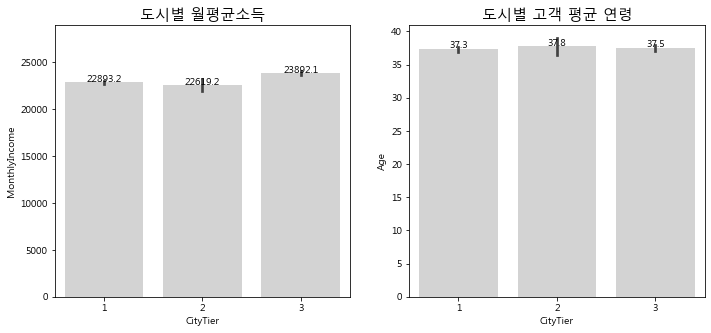

In [28]:
# CityTier 별 고객 월평균소득, 연령 확인  -> 도시별로 고객 특징 차이가 적음
 
plt.figure(figsize=(18,5))
area1= plt.subplot(1,3,1)
ax1=sns.barplot(data=train, x='CityTier', y='MonthlyIncome', color='lightgrey', ax=area1)
write_number(ax1,1)
plt.ylim(0,29000)
plt.title('도시별 월평균소득', fontsize=15)
area2= plt.subplot(1,3,2)
ax2 = sns.barplot(data=train, x='CityTier', y='Age',color='lightgrey', ax=area2)
write_number(ax2,1)
#plt.ylim(0,2.9)
plt.title('도시별 고객 평균 연령', fontsize=15)


####  CityTier 별 
* 고객의 월평균소득 : 3 Tier에서 가장 높았으나, 소득차이가 크지 않음
* 고객의 평균 연령: CityTier와 관계없이 37~38세 정도로 거의 비슷함 

In [29]:
# [MaritalStatus]

# Single, Unmarried, Divorced, Married로 나뉨 -> 미혼상태/기혼상태로 라벨인코딩


# Single/Unmarried/Divorced -> 미혼 
# Married -> 기혼


train['혼인여부'] = train['MaritalStatus'].replace({ 'Single':'미혼',
                                                           'Unmarried':'미혼',
                                                           'Divorced' : '미혼',
                                                           'Married':'기혼'})

In [30]:
train.shape 

(4073, 29)

#### 
#### 
# 3. 고객분석

# 3.1 연령대 별 고객 분석

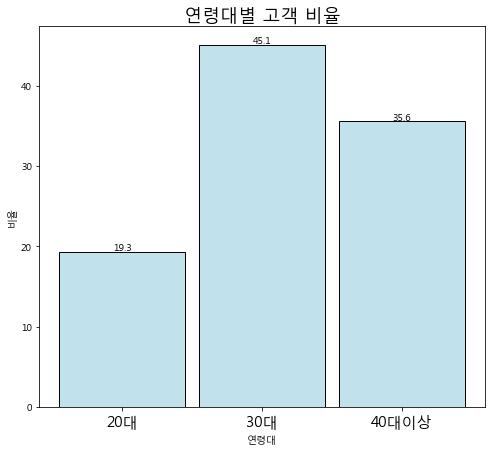

In [31]:
plt.figure(figsize=(8,7))
train['Age_category_str']=train['Age_category'].replace({2:'20대',3:'30대', 4:'40대이상'}).astype('category')
ax = sns.histplot(data= train, x='Age_category_str', shrink=0.9, color='lightblue', stat='percent')
plt.xticks( fontsize=15)
plt.title('연령대별 고객 비율', fontsize=18)
plt.xlabel('연령대', fontsize=10)
plt.ylabel('비율', fontsize=10)
write_number(ax,1)

## (1) 연령대별 고객 비율 

* 전체 방문 고객 중, 30대 고객이 총 45.1%를 차지  

   
* 고객 비율이 높은 연령대순   
30대 (45.1%)    > 40대 이상 (35.5%)       > 20대  (19.3%)     
            
               







No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '전체 고객 계약/미계약 비율')

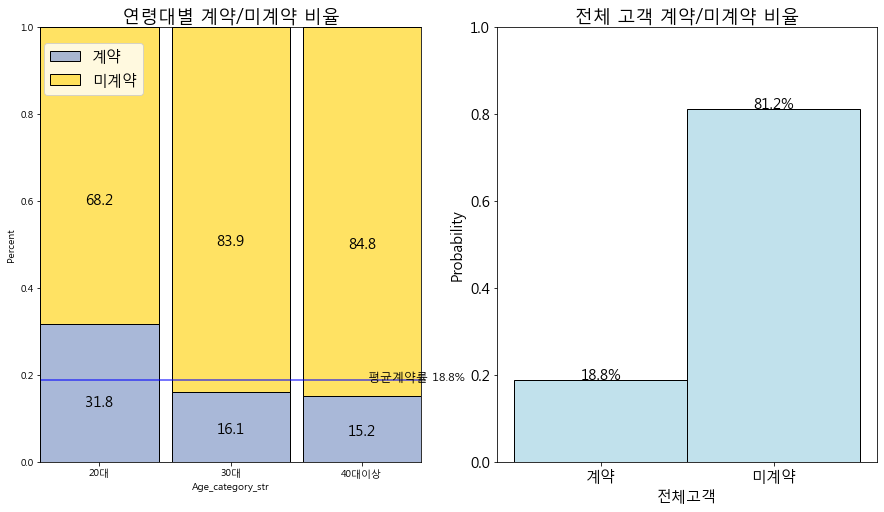

In [32]:
# 연령대별 계약자, 미계약자 비율

plt.figure(figsize=(15,8))
area1=plt.subplot(1,2,1)

train['계약여부'] = train['ProdTaken'].replace({0:'미계약',1:'계약'})
ax = sns.histplot(data=train, x='Age_category_str', ax=area1, hue='계약여부', stat='percent', 
                  palette='Set2_r', multiple='fill', shrink=0.9, hue_order=['미계약','계약'])
plt.legend(loc = 'upper left')
write_percent_3(ax)
plt.legend(['계약','미계약'], prop={'size':15}, bbox_to_anchor=(0.29,0.98))

plt.axhline(0.187, color = 'blue', alpha=0.7)
plt.text(2.05,.18,'평균계약률 18.8%',ha='left', va='bottom', color='black',fontsize=12, rotation=0) 
#bbox={'boxstyle':'round', 'fc':'skyblue','ec':'b','alpha':0.3}
plt.title('연령대별 계약/미계약 비율', fontsize=18)


# 계약고객 / 미계약고객 비율  
plt.rc('font', size=15)
area2=plt.subplot(1,2,2)
ax2 = sns.histplot(x='계약여부', data=train,  stat='probability', ax=area2, color='lightblue')
plt.ylim(0,1)
plt.xlabel('전체고객')
write_percent(ax2,1/100)
ax2.set_title('전체 고객 계약/미계약 비율')

## (2) 연령대별 계약률

#### * 평균 계약률(18.8%) 이상 
20대 (31.8%)

#### * 평균 계약률(18.8%) 미만
30대 (16.1%)      
40대 (15.2%)      

[연령대별 여행 상품 계약 현황]


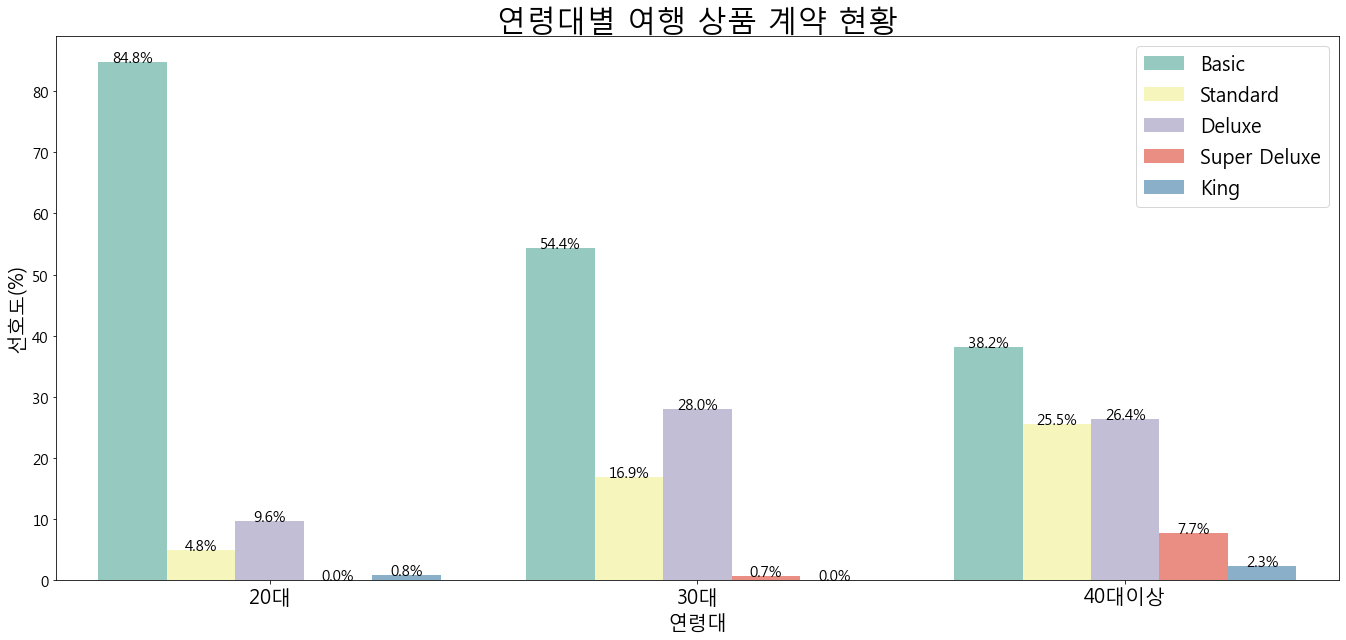

In [33]:
# 연령대별 여행상품 계약 현황 (<-직원 추천 상품을 구매한 것으로 가정)

df_ProdTaken = train[train['ProdTaken']==1] 

# 고객 선호도 (%) 그래프 
a=[]
df = pd.DataFrame(index=['Basic','Standard','Deluxe',
                         'Super Deluxe','King']).reset_index().rename(columns={'index':'여행상품등급'})
for i in ['20대','30대','40대이상'] :
    a = (df_ProdTaken.loc[df_ProdTaken['Age_category_str']==i,'ProductPitched'].value_counts(normalize=True)*100).reset_index()
    a.columns = ['여행상품등급',i]
    df= pd.merge(df,a,on='여행상품등급',how='left')
df.columns= ['여행상품등급', '20대','30대','40대이상']

df2 = pd.melt(df, id_vars='여행상품등급', var_name='연령대',value_name='선호도(%)')
df2 = df2.fillna(0)
plt.figure(figsize=(23,10))



ax1 = sns.barplot(data=df2, x='연령대', y='선호도(%)', hue='여행상품등급', palette='Set3')
write_percent(ax1, 1)
plt.title('연령대별 여행 상품 계약 현황', fontsize=30)
plt.ylabel('선호도(%)', fontsize=20)
plt.xlabel('연령대', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)

print('[연령대별 여행 상품 계약 현황]')


## (3) 연령대별 여행 상품 계약 현황 

####  * 전연령대에 걸쳐, 저가 상품인 Basic 상품 선호도가 가장 높지만, 연령대가 높아지면서 Basic 선호 비율은 점차 감소하는 추세를 보임
#### * 상품 선호 비율은 연령대별로 상이함  
 * 20대 : 저가 상품 선호 경향이 크다. 
 
      
*  30대 : 중저가 상품에 대한 수요가 높다.

   
 * 40대 : 중저가 상품에 대한 수요가 존재하는 한편, 고가 상품(Super Deluxe)에 대한 수요가 다른 연령대 대비 가장 높다.
 
     




[연령대 별 계약 고객의 평균 특성]




,Age,CityTier,MonthlyIncome,PreferredPropertyStar,NumberOfTrips,NumberOfChildrenVisiting,ProductPitched_le
Age_category_str,,,,,,,
20대,26.0,1.6,20541.0,3.6,2.7,1.2,1.5
30대,34.4,1.7,22711.1,3.6,3.3,1.3,2.1
40대이상,47.4,1.7,25246.3,3.6,3.6,1.2,2.6


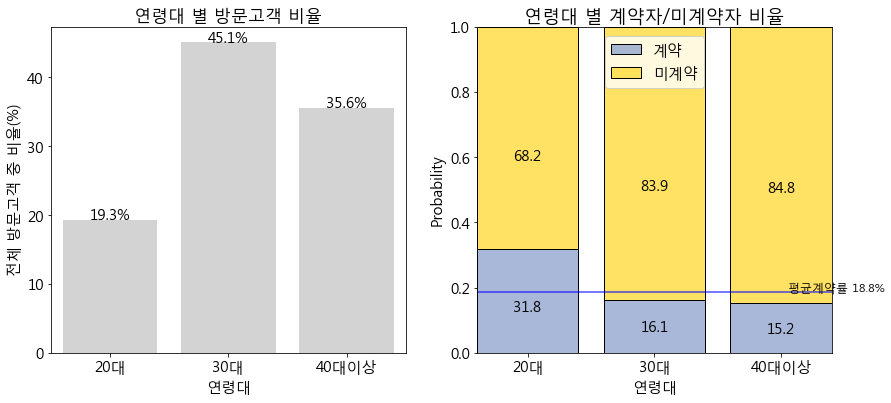

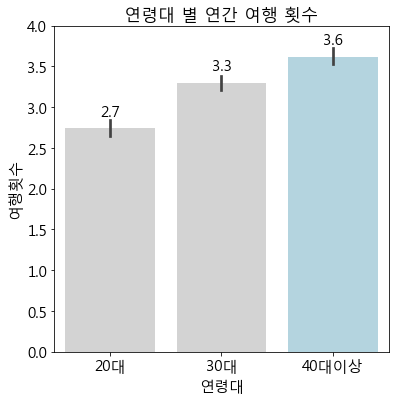

In [34]:
# [ 연령대 별 방문고객 비율(%) ] 

df_방문고객비중 = round(train['Age_category_str'].value_counts(normalize=True)*100,1).reset_index()
df_방문고객비중.columns=['연령대','전체 방문고객 중 비율(%)']

plt.figure(figsize=(14,6))
palette = ['lightgrey','lightgrey','lightgrey' ]
area1= plt.subplot(1,2,1)
ax1 = sns.barplot(data= df_방문고객비중, x='연령대', y='전체 방문고객 중 비율(%)', palette=palette, ax=area1)
plt.xticks(fontsize=15)
plt.title('연령대 별 방문고객 비율', fontsize=17)
write_percent(ax1,1)


# [ 연령대 별 방문고객 계약률(%) ] 
area2 = plt.subplot(1,2,2)  
plt.title('연령대 별 계약자/미계약자 비율', fontsize=18)
ax2 = sns.histplot(train, x='Age_category_str', stat='probability',
                  hue='ProdTaken',  shrink=0.8, multiple='fill', palette='Set2_r', ax= area2)
plt.legend(['계약','미계약'], prop={'size':15}, bbox_to_anchor=(0.5,0.79))

plt.xlabel('연령대')
plt.xticks( ['20대','30대','40대이상'])
write_percent_3(ax2)
plt.axhline(0.187, color = 'blue', alpha=0.7)
plt.text(2.05,.18,'평균계약률 18.8%',ha='left', va='bottom', color='black',fontsize=12, rotation=0) 


# [ 연령대별 연간 여행 횟수 ] 
plt.figure(figsize=(6,6))
palette = ['lightgrey','lightgrey' ,'lightblue']
ax3=sns.barplot(data=train, x='Age_category_str', y='NumberOfTrips', palette=palette, order=['20대','30대','40대이상'])
write_number(ax3,1)
plt.ylim(0,4)
plt.xlabel('연령대')
plt.ylabel('여행횟수')
plt.title('연령대 별 연간 여행 횟수', fontsize=17)


# 연령대 별 계약 고객의 평균 특성
print('[연령대 별 계약 고객의 평균 특성]')
print()
print()
round(train.groupby(['Age_category_str'])[['Age','CityTier','MonthlyIncome','PreferredPropertyStar','NumberOfTrips','NumberOfChildrenVisiting','ProductPitched_le']].mean(),1)


## (4) 고객 연령 별 비지니스 과제 도출

#### * 높은 계약률을 보이는 20대 : 신규 고객 확보 제안

*  20대는 방문 고객 비율(19.3%)이 가장 낮은 그룹이지만 매우 높은 구매전환율(31.8%)을 보인다.
    
* 현재 20대 계약 고객의 데이터를 기반으로 고객 특징을 파악하여, 적극적인 타겟 광고를 진행하는 것을 제안한다.   
   (높은 구매 전환율을 보이기 때문에 마케팅 활동 시 높은 효율이 나타날 가능성이 있다고 봄)
  


#### *  방문 고객 비율이 높은 30대 고객 : 계약률을 올리기 위한 방안 마련 필요

* 30대는 방문 고객 비중이 45.1%로 가장 높지만, 계약율은 16.1%로 평균보다 낮은 수치를 보인다.    
* 신규 고객 확보보다 우선적으로, 현재 방문 고객들의 계약률을 끌어올리는 방안 마련이 필요하다.



#### *  방문 고객 비율이 높은  40대 이상 고객 : 계약률을 올리기 위한 방안 마련 필요

* 40대 이상 고객은 고객 비중이 35.5%를 차지하지만, 계약률은 15.2%로 가장 낮은 수치를 보인다.
* 특히 40대 이상 고객은 연령대 별 연간 여행 횟수가 가장 많은 그룹이며,      
  중저가 상품, 고가 상품(Super Deluxe, King) 수요가 모두 존재하는 연령층으로, 수요 조사를 통해 40대 고객 니즈를 상품에 반영해야 한다.


#### 

# 2.2 고객 분석 - 소득(Monthly Income)별

고객의 소득을 하위 50%, 상위 25~25%, 상위 25%로 나누어서 소득 구간 별 계약 상품 및 계약률을 분석


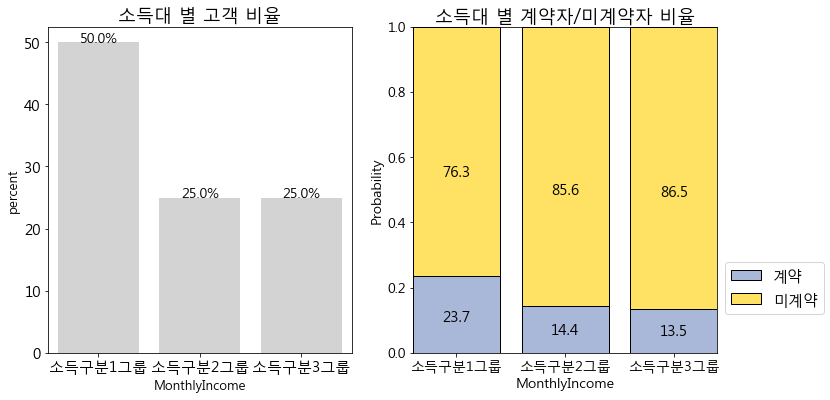

In [35]:
plt.figure(figsize=(12,6)) 
palette=['lightgrey','lightgrey','lightgrey','lightgrey',]
area1 = plt.subplot(1,2,1)    
df = ((train['MonthlyIncome_str'].value_counts(normalize=True)*100).reset_index())
ax1 = sns.barplot(data=df, x = 'index', y='MonthlyIncome_str', palette=palette, ax=area1)
plt.title('소득대 별 고객 비율', fontsize=18)
plt.xlabel('MonthlyIncome', fontsize=13)
plt.ylabel('percent', fontsize=13)
plt.rc('font', size=14)

write_percent(ax1,1)

area2 = plt.subplot(1,2,2)   
train['MonthlyIncome_str']=train['MonthlyIncome_str'].astype('category')
plt.title('소득대 별 계약자/미계약자 비율', fontsize=18)
ax2 = sns.histplot(train, x='MonthlyIncome_str', stat='probability',
                  hue='ProdTaken',  shrink=0.8, multiple='fill', palette='Set2_r', ax= area2)

plt.rc('font', size=13)
plt.legend(['계약','미계약'], prop={'size':15}, bbox_to_anchor=(1,0.3))
plt.xlabel('MonthlyIncome')
#plt.xticks( [1,2,3])
write_percent_3(ax2)



##  (1) 소득대 별 계약률 분석
소득이 증가함에 따라 계약률이 감소하는 경향이 나타난다.

#### * 전체 평균(18.8%) 이상의 계약률을 보이는 그룹
    소득구간 1 그룹

#### * 전체 평균(18.8%) 이하의 계약률 보이는 그룹
    소득구간 2그룹, 소득구간 3그룹



(array([0, 1, 2]),
 [Text(0, 0, '소득구분1그룹'), Text(1, 0, '소득구분2그룹'), Text(2, 0, '소득구분3그룹')])

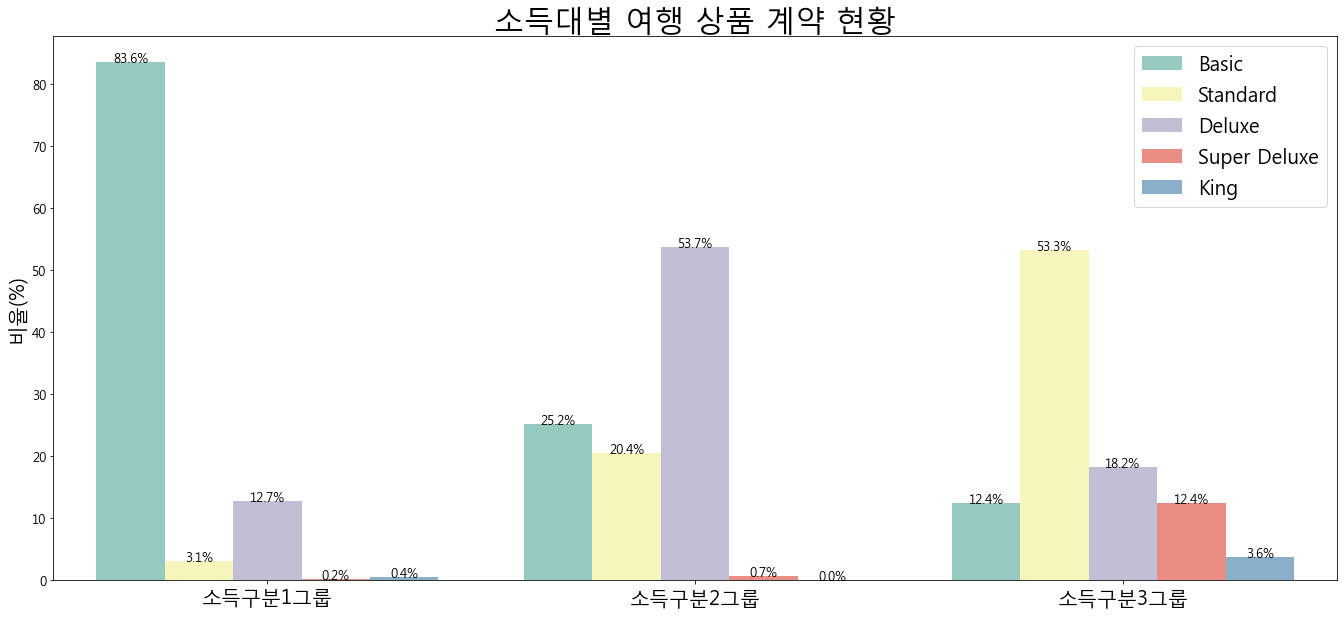

In [36]:
# 소득별 여행상품 계약 현황 (<-기본 가정 : 직원 추천 상품을 구매한 것으로 가정)

df_ProdTaken = train[train['ProdTaken']==1] 

# 소득별 상품별 고객 계약 현황 (%) 그래프 
a=[]
df = pd.DataFrame(index=['Basic','Standard','Deluxe',
                         'Super Deluxe','King']).reset_index().rename(columns={'index':'여행상품등급'})
for i in [1,2,3] :
    a = (df_ProdTaken.loc[df_ProdTaken['MonthlyIncome_str']==f'소득구분{i}그룹','ProductPitched'].value_counts(normalize=True)*100).reset_index()
    a.columns = ['여행상품등급',f'소득구분{i}그룹']
    df= pd.merge(df,a,on='여행상품등급',how='left')

df2 = pd.melt(df, id_vars='여행상품등급', var_name='연령대',value_name='비율(%)')
df2 = df2.fillna(0)
plt.figure(figsize=(23,10))



ax1 = sns.barplot(data=df2, x='연령대', y='비율(%)', hue='여행상품등급', palette='Set3')
write_percent(ax1, 1)
plt.title('소득대별 여행 상품 계약 현황', fontsize=30)
plt.ylabel('비율(%)', fontsize=20)
plt.xlabel(' ', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)

## (2) 소득별 여행상품 계약 현황
계약 고객은 직원 추천 상품(ProductPitched)을 구매한 것으로 가정하였다.

#### *  1그룹 (소득 하위 0~50%) 
    대부분 중저가 상품을 계약하였으며 
    특히, 저가 상품 (Basic) 계약 비율이 83.6%로 매우 높다.
     
     
#### *  2그룹 (소득 상위 25%~50%)

    대부분 중저가 상품을 계약하였다.
    1그룹에 비해 저가 상품(Basic, Standard) 계약 비율이 줄고 중간 가격대 상품(Deluxe) 계약 비율이 증가하였다.

   
 
#### *  3그룹 (소득 상위 0~25%)
    
    저가~고가 상품에 대한 수요가 모두 존재하며, 고가 상품 계약 비율이 다른 그룹에 비해 높은 수치를 보인다.
    예상밖으로 저가 Standard 상품 계약 비율이 가장 높다. **
    
##### 문제점 :  소득 구분 3 그룹의 저가 상품 계약 비율이 높은 이유
 ( 아래 (3) 소득별 영업사원 추천 상품 비율 및 계약률 분석에서 확인 가능 )     
a. 소득 구분 3그룹에 저가 상품에 대한 추천 비율이 가장 높았으며,      
b. 고가 상품 계약률이 저조하여 상대적으로 저가 상품 비율이 커지게 된 것에서 연유한다.          



## (3) 소득별 영업사원 추천 상품 비율 및 계약률 분석 


([<matplotlib.axis.XTick at 0x7fa1f81cbc10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

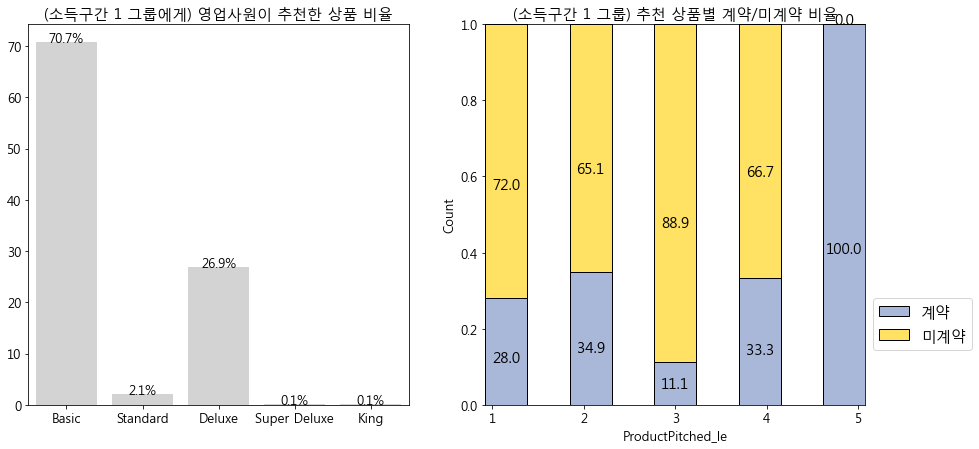

In [37]:
plt.figure(figsize=(15,7))
area1 = plt.subplot(1,2,1)
df = round(train.loc[train['MonthlyIncome_2']==1,'ProductPitched'].value_counts(normalize=True)*100, 1)
ax1 = sns.barplot( x=df.index, y=df.values, ax=area1, color='lightgrey', order=['Basic','Standard','Deluxe','Super Deluxe', 'King'])
write_percent(ax1,1)
plt.title('(소득구간 1 그룹에게) 영업사원이 추천한 상품 비율', fontsize=15)
area2 = plt.subplot(1,2,2)
train['ProductPitched']=train['ProductPitched'].astype('category')

ax2=sns.histplot(train[(train['MonthlyIncome_2']==1)], 
                 x='ProductPitched_le',palette='Set2_r',  hue = '계약여부',
                 hue_order=['미계약','계약'], multiple='fill', shrink=1.5, ax=area2)
plt.legend(['계약','미계약'], prop={'size':15}, bbox_to_anchor=(1,0.3))
write_percent_3(ax2)
plt.title('(소득구간 1 그룹) 추천 상품별 계약/미계약 비율', fontsize=15)
plt.xticks([1,2,3,4,5])

#### 
### A.  소득구간 1그룹 (소득 상위 50~100%) 
* 중저가 상품 위주로 상품 추천이 이루어짐
  
#### 문제점   
* 중간 가격대 Deluxe 상품의 추천 비율이 높은데 비해 계약률은 가장 저조함 (11.1%)
* 저가 Standard 상품 계약률은 매우 높으나(34.9%), 상품 추천 비율이 낮음(2.1%)


#### 제안
* 계약률이 저조한 Deluxe 추천 비율을 줄이고, Standard 추천 비율을 높이는 방향으로, 추천 기준 변경을 검토할 필요가 있다. 

#### 

([<matplotlib.axis.XTick at 0x7fa1f84f44f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

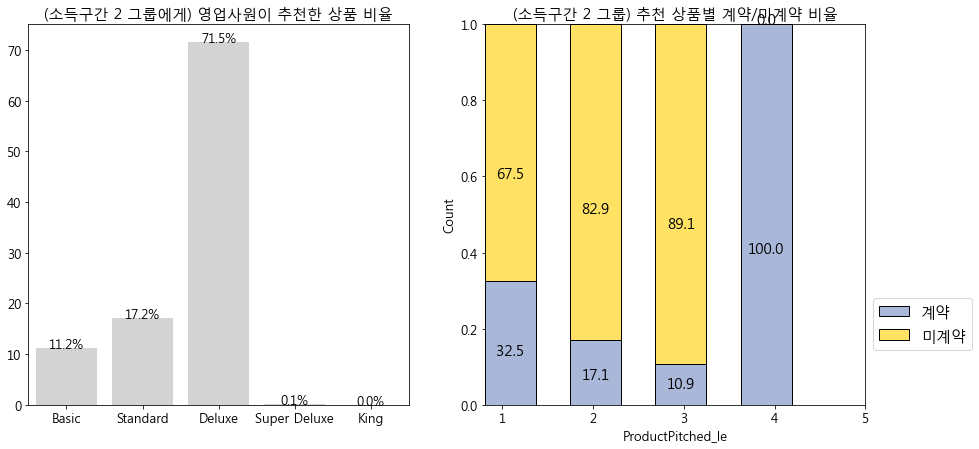

In [38]:
plt.figure(figsize=(15,7))
area1 = plt.subplot(1,2,1)
df = round(train.loc[train['MonthlyIncome_2']==2,'ProductPitched'].value_counts(normalize=True)*100, 1)
ax1 = sns.barplot( x=df.index, y=df.values, ax=area1, color='lightgrey', order=['Basic','Standard','Deluxe','Super Deluxe', 'King'])
write_percent(ax1,1)
plt.title('(소득구간 2 그룹에게) 영업사원이 추천한 상품 비율', fontsize=15)
area2 = plt.subplot(1,2,2)
train['ProductPitched']=train['ProductPitched'].astype('category')
ax2=sns.histplot(train[(train['MonthlyIncome_2']==2)], 
                 x='ProductPitched_le',palette='Set2_r',  hue = '계약여부',
                 hue_order=['미계약','계약'], multiple='fill', shrink=3, ax=area2)
plt.legend(['계약','미계약'], prop={'size':15}, bbox_to_anchor=(1,0.3))
write_percent_3(ax2)
plt.title('(소득구간 2 그룹) 추천 상품별 계약/미계약 비율', fontsize=15)
plt.xticks([1,2,3,4,5])

### B. 소득구간 2그룹 (소득 상위 25~50%)

* 소득구간 2그룹에게는 중저가 상품이 추천되었으며, 특히 중간 가격대 Deluxe 상품 추천이 가장 많이 이뤄졌다.(약 71.5%)

#### 문제점
* 가장 많이 추천된 Deluxe 상품의 계약률이 10.9%로 가장 낮은 것을 고려할 때, 
  소득구간 2그룹에게 Deluxe상품이 매력적이지 않은 것으로 보인다.
* 저가 상품에 대한 계약률은 비교적 높게 나타났으나, 추천이 많이 이뤄지지 않았다.
  
#### 제안 
* 소득 구간 2그룹에게 저가 상품(Basic, Standard) 추천 비중을 늘리는 쪽으로 추천 기준을 변경하거나,    
  Deluxe 상품을 2그룹 니즈에 맞게 품질, 가격, 구성 등을 변경할 필요가 있다.

Text(0.5, 1.0, '(소득구간 3 그룹) 추천 상품별 계약/미계약 비율')

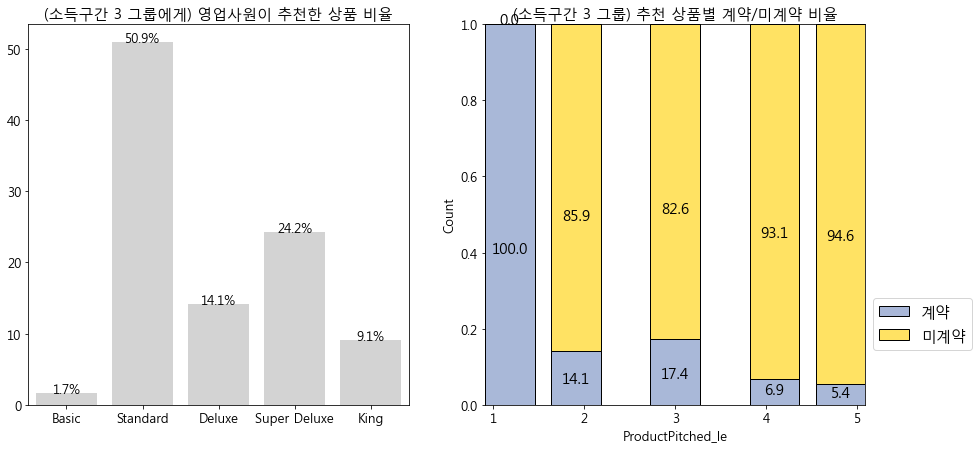

In [39]:
plt.figure(figsize=(15,7))
area1 = plt.subplot(1,2,1)
df = round(train.loc[train['MonthlyIncome_2']==3,'ProductPitched'].value_counts(normalize=True)*100, 1)
ax1 = sns.barplot( x=df.index, y=df.values, ax=area1, color='lightgrey', order=['Basic','Standard','Deluxe','Super Deluxe', 'King'])
write_percent(ax1,1)
plt.title('(소득구간 3 그룹에게) 영업사원이 추천한 상품 비율', fontsize=15)
area2 = plt.subplot(1,2,2)
train['ProductPitched']=train['ProductPitched'].astype('category')
ax2=sns.histplot(train[(train['MonthlyIncome_2']==3)], 
                 x='ProductPitched_le',palette='Set2_r',  hue = '계약여부',
                 hue_order=['미계약','계약'], multiple='fill', shrink=1.5, ax=area2)
plt.legend(['계약','미계약'], prop={'size':15}, bbox_to_anchor=(1,0.3))
write_percent_3(ax2)
plt.xticks([1,2,3,4,5])
plt.title('(소득구간 3 그룹) 추천 상품별 계약/미계약 비율', fontsize=15)


### C. 소득구간 3그룹 (소득 상위 0~25%)
* 소득구간 3그룹에게는 저가 상품과 고가 상품이 모두 추천되었다.
 
#### 문제점 
* 고가 상품 Super Deluxe, King 계약률이 6.9%, 5.4%로 매우 저조한 상황이다. 
* 소득 수준이 가장 높은 3그룹에게 저가 상품 추천 비율이 매우 높다.(50.9%)      
  (소득구간 3그룹에서 예상밖으로 저가 Standard 상품 계약 비율이 가장 높았던 이유는 또한 이 두 가지 문제점에서 연유한다.)

#### 제안 : 추천 기준과 고가 상품 상품 품질, 구성, 서비스, 마케팅에 걸쳐 전반적인 검토 및 수정 개선 두 가지가 필요한 상황이다.    
 * 현재 Standard 추천 비율이 가장 높은데, 높은 계약률을 보이는 Deluxe 상품 추천 비율을 높이는 방향으로 추천 기준을 변경하는 것을 고려해 볼 필요가 있다.
 * 고가 상품 계약률이 저조하기 때문에, 소득구간 3그룹의 니즈에 맞게 고가 상품(Super Deluxe, King) 품질, 구성, 서비스, 마케팅에 걸쳐 전반적인 검토 및 수정이 필요해보인다.


#### 

#  2.3  고객분석  - City Tier별


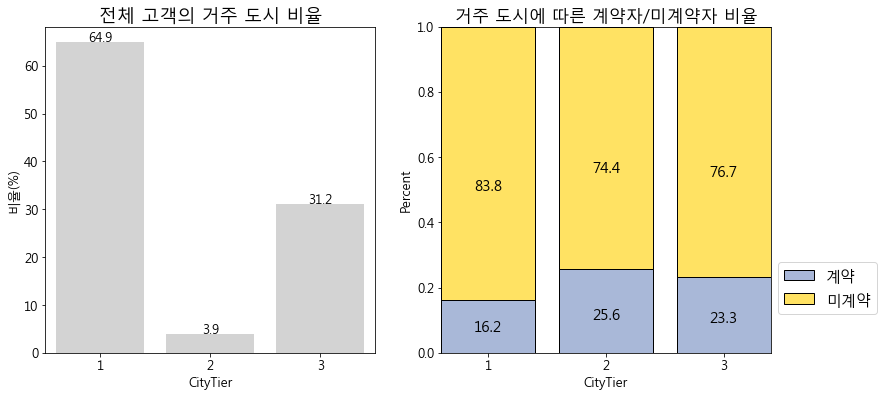

In [40]:
plt.figure(figsize=(13,6))
area1=plt.subplot(1,2,1)
df = train['CityTier'].value_counts(normalize=True)*100
ax1 = sns.barplot(x=df.index, y=df.values, ax=area1,color='lightgrey') 
plt.title('전체 고객의 거주 도시 비율', fontsize=18)
plt.xlabel('CityTier', fontsize=13)
plt.ylabel('비율(%)', fontsize=13)

write_number(ax1,1)

train['CityTier']=train['CityTier'].astype('category')
area2=plt.subplot(1,2,2)
ax2 = sns.histplot(train, x='CityTier', stat='percent', palette='Set2_r',
                  hue='ProdTaken',  multiple='fill', ax=area2, shrink=0.8)

plt.legend(['계약','미계약'], prop={'size':15}, bbox_to_anchor=(1,0.3))
plt.xlabel('CityTier')
plt.xticks( [1,2,3])
plt.title('거주 도시에 따른 계약자/미계약자 비율', fontsize=17)
write_percent_3(ax2)

## (1) 전체 고객의 거주 도시 비율     

1 Tier : 고객 비율이 가장 높지만(65%), 계약률은 가장 낮다.(16%)

2 Tier : 고객 비율이 매우 낮지만(4%) 계약률은 가장 높다.(25.5%)

3 Tier : 고객 비율이 두 번째로 높고(31%), 계약률은 전체 평균 계약률보다 높다.(23%)



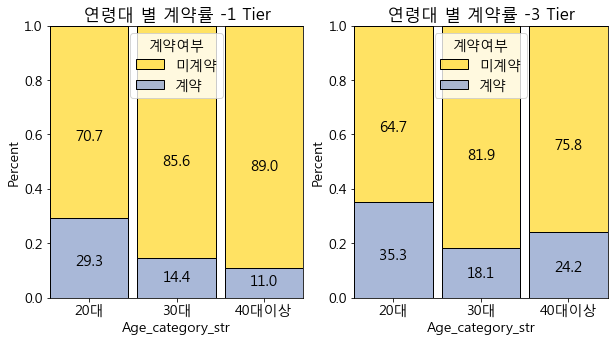

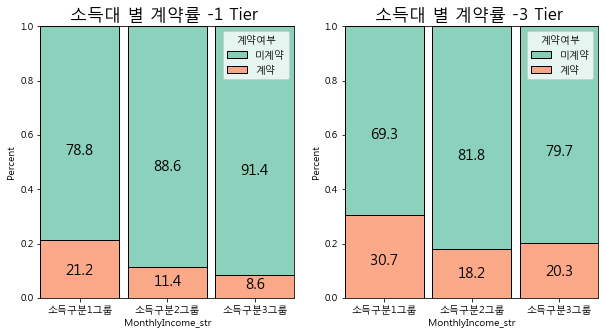

In [41]:
plt.figure(figsize=(10,5))

k=1
for j in [1,3] : 
    train['Age_category_str']=train['Age_category_str'].astype('category')
    plt.rc('font', size=14)
    ax1 = sns.histplot(data=train[train['CityTier']==j], x='Age_category_str' , palette='Set2_r', 
                       ax=plt.subplot(1,2,k) , stat='percent' ,
                       hue='계약여부', multiple='fill', shrink=0.9, hue_order=['미계약','계약'] ) 
    write_percent_3(ax1)
    plt.title(f'연령대 별 계약률 -{j} Tier', fontsize=17)
    k+=1 
 
plt.figure(figsize=(10,5))

k=1
for j in [1,3] : 
    train['MonthlyIncome_str']=train['MonthlyIncome_str'].astype('category')
    plt.rc('font', size=10)
    ax1 = sns.histplot(data=train[train['CityTier']==j], x='MonthlyIncome_str' , palette='Set2', 
                       ax=plt.subplot(1,2,k) , stat='percent' ,
                       hue='계약여부', multiple='fill', shrink=0.9, hue_order=['미계약','계약'] ) 
    write_percent_3(ax1)
    plt.title(f'소득대 별 계약률 -{j} Tier ', fontsize=17)
    k+=1  
    


## (2) 도시 별 계약률 비교 - 1Tier, 3Tier
####  연령대별, 소득별로 도시별 계약률을 비교해보도록 한다. (고객비중이 적은 2 Tier 도시는 제외) 


* 연령대 별, 소득대 별로 두 도시를 비교했을 때, 모두 3 Tier 도시의 계약률이 높다.     
* 특히, 연령대 별로는 40대 이상, 소득대 별로는 3그룹에서는 계약률의 2배 이상 차이가 나타났다.
#### 

## (3)  비지니스 과제 도출
* 도시별 고객 특징에서는 큰 차이가 나타나지 않았기 때문에, 도시별 마케팅 활동에서 차이가 있는지 확인해 볼 필요가 있다.          
  3 Tier 도시에서의 마케팅 전략을 다른 도시에 벤치마킹 / 적용하는 것에 대해 고려해 볼 필요가 있다.

# 4. 영업 데이터 분석 
# 4.1 영업사원의 추천 상품 (ProductPitched)


p value:  9.081225375406546e-40

[ProductPitched_le] : 고객이 영업사원에게 추천 받은 상품 등급

Basic : 1, Standard : 2,  Deluxe : 3, Super Deluxe : 4, King : 5



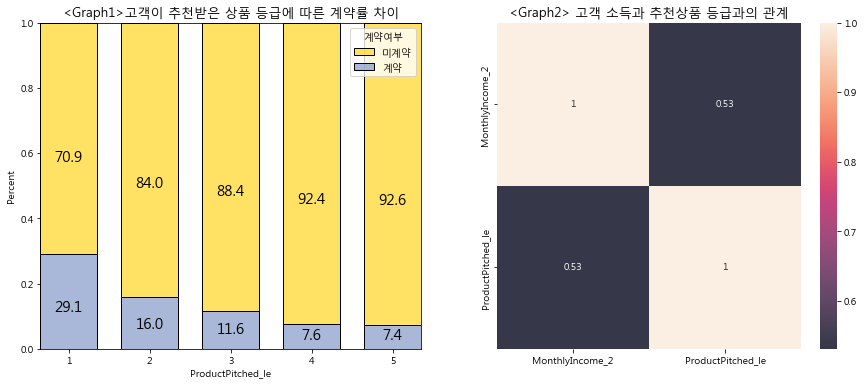

In [42]:
# [고객 소득과 추천 상품 등급과의 관계]
plt.figure(figsize=(15,6))

area1 = plt.subplot(1,2,1)
train['ProductPitched_le']=train['ProductPitched_le'].astype('category')
ax = sns.histplot(data=train, x='ProductPitched_le', hue='계약여부', stat='percent', multiple='fill', palette='Set2_r',
                  hue_order=['미계약','계약'], shrink=0.7, ax=area1)
write_percent_3(ax)
plt.title('<Graph1>고객이 추천받은 상품 등급에 따른 계약률 차이', fontsize=13)

area2 = plt.subplot(1,2,2)

train['ProductPitched_le']=train['ProductPitched_le'].astype('int')    
train['MonthlyIncome_2']=train['MonthlyIncome_2'].astype('int')    

corr= train[['MonthlyIncome_2','ProductPitched_le']].corr()

plt.rcParams['figure.figsize'] = [6,6]
sns.heatmap(corr, annot= True, ax=area2,  alpha=0.8)
plt.title('<Graph2> 고객 소득과 추천상품 등급과의 관계', fontsize=13)



# ProductPitched_le : 고객이 추천 받은 상품
    # Basic : 1
    # Standard : 2
    # Deluxe : 3
    # Super Deluxe : 4
    # King : 5


#  추천 상품과 계약 여부와의 관계 파악을 위하여 카이제곱분석 진행
chi2, p, dof, expected_ = chi2_contingency( pd.crosstab(train['ProductPitched'],train['ProdTaken']))
print('p value: ', p)

print()
print('[ProductPitched_le] : 고객이 영업사원에게 추천 받은 상품 등급')
print()
print('Basic : 1, Standard : 2,  Deluxe : 3, Super Deluxe : 4, King : 5')
print()

## (1)  영업사원의 추천 상품 (ProductPitched) 분석
#### * 분석 필요성 :
카이제곱분석을 통해 영업 사원의 추천 상품(ProductPitched)은 고객의 계약 여부(ProdTaken)에 영향을 줄 수 있다는 것을 확인했으며 (p value 0.05이하)    
위의 그래프1를 통해서도 추천 상품에 따라 고객의 계약률이 크게 차이가 나는 것을 볼 수 있다.    
따라서 영업 사원의 상품 추천이 제대로 이뤄지고 있는지 파악하는 것을 중요하다.  


#### * 영업 사원 추천 상품을 고객 소득별로 나누어 분석해야 하는 이유 : 
위의 그래프2를 통해서 확인되었듯이, 고객의 소득이 증가함에 따라 영업사원의 추천 상품 등급도 상향되는 상관관계를 갖는다. (상관계수: 0.53)   
따라서 소득별로 추천 상품이 달라질 수 있기 때문에, 소득 구분을 나눠 영업사원 추천 상품 및 계약률을 확인해보도록 한다.
 

### 

## (2) 소득대 별, 영업사원의 추천 상품 가격대와 고객 실제 계약 가격대 비율 비교
    상품을 가격대별로 라벨링 한 후에 영업사원의 추천 상품 가격대 비율과 실제 고객 계약 상품 가격대 비율을 확인한다.
     - Basic, Standard 상품 : Low price
     - Deluxe 상품 : Medium price
     - Super Deluxe , King 상품 : High price

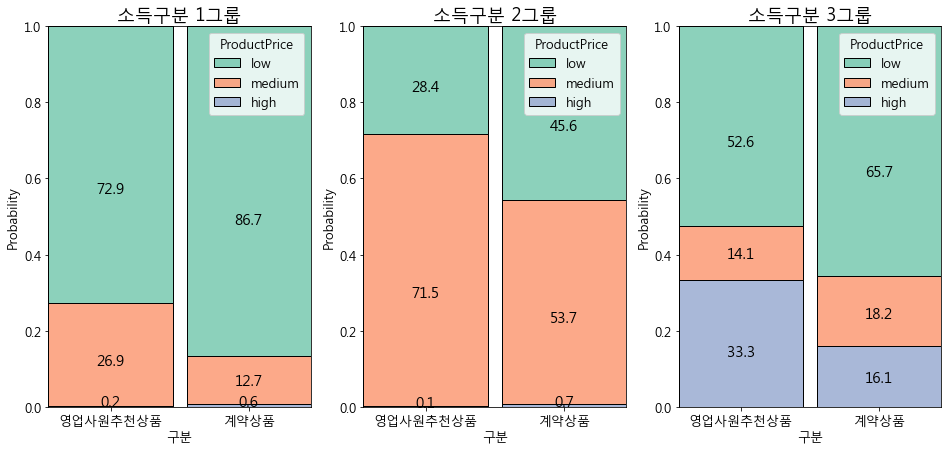

In [43]:
train['ProductPrice'] = train['ProductPitched'].replace({'Basic': 'low', 'Standard':
                                                         'low','Deluxe': 'medium',
                                                         'Super Deluxe': 'high','King':'high'})
plt.figure(figsize=(16,7))
           
for i in range(1,4) :
    df상품추천 = train.loc[train['MonthlyIncome_2']==i,'ProductPrice'].reset_index()
    df상품계약 = train.loc[(train['ProdTaken']==1)&(train['MonthlyIncome_2']==i),'ProductPrice'].reset_index()
    df상품추천['구분']='영업사원추천상품'
    df상품계약['구분']='계약상품'
    plt.rc('font', size=13)
    plt.subplot(1,3,i)
    plt.title(f'소득구분 {i}그룹', fontsize=18)
    ax = sns.histplot(data = pd.concat([df상품추천,df상품계약],0).reset_index(), hue='ProductPrice', x='구분', 
                 shrink=0.9, multiple='fill', hue_order=['low','medium','high'], stat='probability', palette='Set2')
    write_percent_3(ax)    



#### 영업사원이 상품 추천 시에 [고객의 실제 선호보다 다소 높은 등급(고가)의 상품을 더 많이 추천하는 경향]이 나타난다.
즉, 고객에게 가격대가 낮은 제품은 더 적게, 높은 제품은 더 많이 추천하려는 경향이 있다.  

* 예) 위의 그래프 소득구분 1그룹에서,           
  영업사원은 medium price 상품은 실제 게약 비율(12.7%)보다 많이 추천(26.9%)하였으며,    
  low price 상품은 실제 계약 비율(86.7%)보다 적게 추천(72.9%)하였다.
  
  위의 그래프 소득구분 3그룹에서, High price 상품은 실제 게약 비율(16.1%)보다 많이 추천(33.3%)하였으며,    
  low price 상품은 실제 계약 비율(65.7%)보다 적게 추천(52.6%)하였다.
  
  



## (3) 영업사원의 추천 상품 - 계약자/미계약자 사이에 나타나는 차이 
영업 사원의 추천 상품을 등급이 높으면 숫자가 증가하도록 라벨 인코딩하고     
(Basic : 1, Standard : 2, Deluxe : 3, Super Deluxe : 4, King : 5)   
고객을 계약자 / 미계약자로 나눠 추천 받은 상품의 평균 등급을 소득별로 구해보도록 한다.    


[ProductPitched_le] : 고객이 추천 받은 상품 등급

Basic : 1, Standard : 2,  Deluxe : 3, Super Deluxe : 4, King : 5



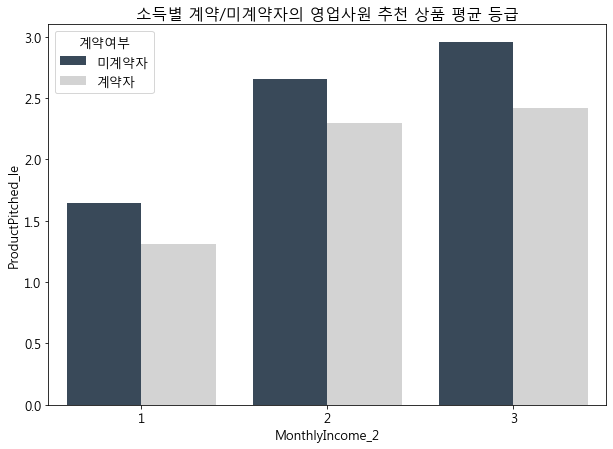

In [44]:
train['ProductPitched_le']=train['ProductPitched_le'].astype('int')
df_ProdTaken = train[train['계약여부']=='계약']
df_ProdUntaken = train[train['계약여부']=='미계약']
df_ProdTaken = df_ProdTaken.groupby('MonthlyIncome_2')['ProductPitched_le'].mean().reset_index()
df_ProdTaken['계약여부']='계약자'
df_ProdUntaken = df_ProdUntaken.groupby('MonthlyIncome_2')['ProductPitched_le'].mean().reset_index()
df_ProdUntaken['계약여부']='미계약자'

plt.figure(figsize=(10,7))
ax = sns.barplot(data = pd.concat([df_ProdTaken,df_ProdUntaken ],0), x='MonthlyIncome_2',y='ProductPitched_le',hue='계약여부', palette=['#34495e','lightgrey'], hue_order=['미계약자','계약자'])
plt.title('소득별 계약/미계약자의 영업사원 추천 상품 평균 등급')


print()
print('[ProductPitched_le] : 고객이 추천 받은 상품 등급')
print()
print('Basic : 1, Standard : 2,  Deluxe : 3, Super Deluxe : 4, King : 5')
print()

소득별로 계약자/미계약자가 추천 받은 상품 등급의 평균을 비교했을 때,  
#### 미계약 고객이 추천 받은 상품의 등급 평균이 계약 고객이 추천 받은 상품 등급의 평균보다 높게 나타났다.    

##### Insight : 고객의 수요보다 높은 등급의 상품을 추천할 때, 계약에 어느정도 부정적인 영향을 줄 수도 있다고 추측된다.

#### 
## (4) 영업사원의 추천 상품 관련 비지니스 과제 도출 

#### 문제
* 현재 영업사원이 고객의 실제 수요보다 높은 상품 등급을 추천하는 경향이 있으며 이는 계약에 부정적인 영향을 줄 수도 있다는 가설을 도출하였다.

#### 제안

* 계약률을 올리기 위해서, 고객의 데이터 기반으로 고객 선호 상품을 예측하여 상품을 추천 하는 것을 제안한다. 
#### 

## (5) 고객 데이터 기반 상품 수요 예측 모델 개발

####  A. 데이터 준비
* 계약 고객(ProdTaken==1)의 데이터를 train data로 사용해, 예측 모델을 만든다. 
* 고객 기본 데이터를 활용한 고객 상품 수요 예측이기 때문에 영업 관련 데이터는 삭제하고 고객 관련 데이터만 남긴다. 
* 단, 월 소득은 민감한 정보이기 때문에 실제 사용이 어려울 것으로 판단되어 모델 생성 시 배제한다.


In [45]:
train['CityTier'] = train['CityTier'] .astype('int')

df_ProdTaken = train[train['ProdTaken']==1]
df_ProdUntaken = train[train['ProdTaken']==0]

X_train = df_ProdTaken.drop(['ProdTaken','ProductPitched_le', 'PitchSatisfactionScore', 
                             'DurationOfPitch','NumberOfFollowups','DurationOfPitch(주별)'],1) 
Y_train = df_ProdTaken['ProductPitched_le']
test = df_ProdUntaken.drop(['ProdTaken','ProductPitched_le', 'PitchSatisfactionScore',
                            'DurationOfPitch','NumberOfFollowups','DurationOfPitch(주별)'],1) 


In [46]:
# 라벨 인코딩 
from sklearn.preprocessing import LabelEncoder
for i in ['Occupation', 'MaritalStatus','Gender'] :
    le = LabelEncoder()
    X_train[i] = le.fit_transform(X_train[i])
    test[i] = le.transform(test[i])

In [47]:
train.columns

Index(['ProdTaken', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'MonthlyIncome', 'Age_category',
       'Age_category_str', 'Age_category_2', 'DurationOfPitch(주별)',
       'MonthlyIncome_2', 'MonthlyIncome_range', 'MonthlyIncome_str',
       'ChildrenVisiting', 'ProductPitched_le', 'ProductPrice', '혼인여부',
       '계약여부'],
      dtype='object')

In [48]:
# 나머지 필요없는 컬럼 및 문자 컬럼은 drop +  소득은 민감한 정보이기 때문에 drop

df_train = X_train.drop(['혼인여부', 'ChildrenVisiting','TypeofContact', 'ProductPitched','MonthlyIncome_2', 'MonthlyIncome','MonthlyIncome_range',
                        'MonthlyIncome_str','계약여부','Age_category_str','ProductPrice','NumberOfPersonVisiting'],1).reset_index(drop=True)
df_test = test.drop([   '혼인여부', 'ChildrenVisiting','TypeofContact', 'ProductPitched','MonthlyIncome_2', 'MonthlyIncome','MonthlyIncome_range',
                        'MonthlyIncome_str','계약여부','Age_category_str','ProductPrice','NumberOfPersonVisiting'],1).reset_index(drop=True)
y_train = Y_train.reset_index(drop=True)

In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       766 non-null    float64
 1   CityTier                  766 non-null    int64  
 2   Occupation                766 non-null    int64  
 3   Gender                    766 non-null    int64  
 4   PreferredPropertyStar     766 non-null    float64
 5   MaritalStatus             766 non-null    int64  
 6   NumberOfTrips             766 non-null    float64
 7   Passport                  766 non-null    int64  
 8   OwnCar                    766 non-null    int64  
 9   NumberOfChildrenVisiting  766 non-null    float64
 10  Age_category              766 non-null    float64
 11  Age_category_2            766 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 71.9 KB


#### B. 모델링
- CatBoostClassifier
- RandomForestClassifier 

In [50]:
# CatBoost 모델 생성 결과 
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import mean_absolute_error , f1_score, accuracy_score, mean_squared_error 

cv_accuracy={}
cv_f1_score={}
k = 0    
result=0
# 평가 지표 NMAE
kf = StratifiedKFold(n_splits = 5)
kf_split  = kf.split(df_train, Y_train)    

for train_idx ,valid_idx in kf_split:
    x_train = df_train.iloc[ train_idx ]
    y_train = Y_train.iloc[ train_idx ]

    x_valid = df_train.iloc[ valid_idx ]
    y_valid = Y_train.iloc[ valid_idx ]        
    k += 1 
    cb = CatBoostClassifier(verbose=False, iterations= 2028, learning_rate=0.02150689886701414, depth= 10)
    model_cb = cb.fit(x_train, y_train)
    pred = model_cb.predict(x_valid)
    result = accuracy_score(y_valid, pred)
    result2=f1_score(y_valid, pred,average='weighted')
    cv_accuracy[k]=result
    cv_f1_score[k]=result2
accuracy_score_ = (cv_accuracy[1] + cv_accuracy[2] +cv_accuracy[3] + cv_accuracy[4] + cv_accuracy[5])/5
f1_score_ = (cv_f1_score[1]+cv_f1_score[2]+cv_f1_score[3]+cv_f1_score[4]+cv_f1_score[5])/5

print('score')
print( f'f1_score: {f1_score_}')
print( f'accuracy_score : {accuracy_score_}')

score
f1_score: 0.9130297997929372
accuracy_score : 0.9137933961463374


In [51]:
#model_cb
pd.DataFrame(model_cb.feature_importances_, index=df_train.columns).sort_values(0, ascending=False)

,0
CityTier,17.305324
Age,10.199161
MaritalStatus,9.880163
PreferredPropertyStar,9.573479
Occupation,9.452749
Passport,9.330516
NumberOfTrips,8.356573
Age_category_2,6.895550
Gender,5.698393
Age_category,5.532917


#### C. Optuna 튜닝 결과     
* Best Score: 1.0     
* Best trial: {'random_state': 45, 'n_jobs': 180, 'max_depth': 8}

#### (5)-4 최종 모델의 변수 중요도

<AxesSubplot:xlabel='변수중요도', ylabel='변수'>

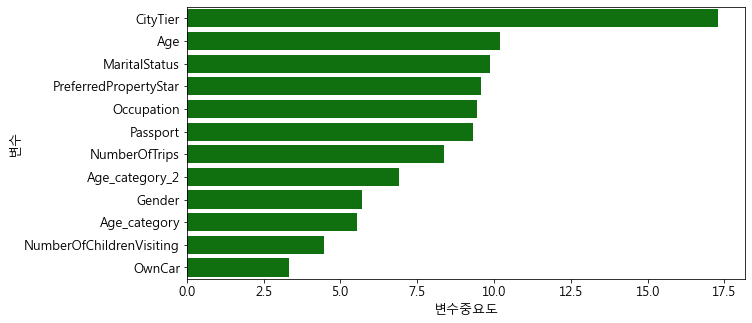

In [52]:
feature_importances = pd.DataFrame(model_cb.feature_importances_, index=df_train.columns, 
                                   columns=['변수중요도']).sort_values('변수중요도', ascending=False).reset_index().rename(columns={'index':'변수'})
plt.figure(figsize=(10,5))
sns.barplot(data=feature_importances, x='변수중요도', y='변수', orient='h', color='green')

# 4.2 그 외  영업 관련 데이터 분석 

In [53]:
# 서비스 관련 변수들로, 계약률이 어떻게 달라지는지 확인해본다. 
# TypeofContact 고객의 방문 경로
# PitchSatisfactionScore 추천 만족도
# DurationOfPitch 추천 기간

cols = [ 'TypeofContact','PitchSatisfactionScore','DurationOfPitch(주별)']
li=[]

for x in cols :
    chi2, p, dof, expected_ = chi2_contingency( pd.crosstab(train[x],train['ProdTaken']))
    if p > 0.05:
        li.append(x)
    else :
        실제 = pd.crosstab(train[x],train['ProdTaken']).rename(columns = {0:'실제_0',1:'실제_1'})
        예상 = pd.DataFrame(expected_,columns=['예상_0','예상_1'])
        pd.concat([예상,실제], 1)
        expected_rate = round((예상['예상_1']/예상.sum(axis=1)).values[0]*100,1)
        print()
        print(round(실제['실제_1']/실제.sum(axis=1)*100,1))
        print(round(p,10))
print(f'pass : {li}')   


TypeofContact
Company Invited    22.0
Self Enquiry       17.5
dtype: float64
0.0011405538

PitchSatisfactionScore
1    15.5
2    15.4
3    21.7
4    17.6
5    21.0
dtype: float64
0.0006361607

DurationOfPitch(주별)
0.0    12.9
1.0    16.3
2.0    19.1
3.0    22.1
4.0    28.2
5.0    17.2
dtype: float64
4.33e-08
pass : []


#### TypeofContact :  
Company Invited(회사 영업/마케팅을 통해 상품을 접한) 그룹이 Self Enquiry 그룹보다 계약률이 더 높다.

#### PitchSatisfactionScore 
추천만족도가 1, 2점일경우 계약률이 매우 낮기 때문에, 3점이상 받을 수 있도록 해야 한다.

#### DurationOfPitch(주별) :  
4주까지는 영업 기간이 길 수록 계약률이 높아지다가 5주 이상인 경우 다시 감소한다.

NumberOfFollowups,1.0,2.0,3.0,4.0,5.0,6.0
계약률(%),13.3,10.2,16.1,18.2,24.9,39.5


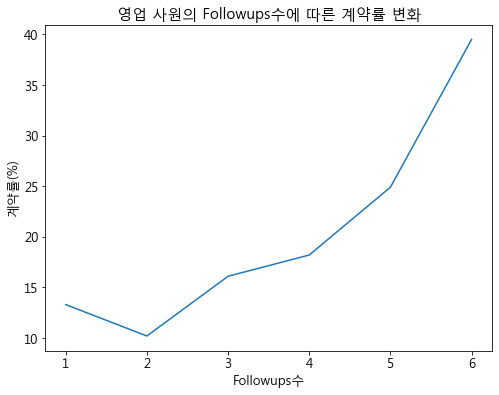

In [54]:
# 영업 사원의 Followups수에 따른 계약률 변화

cross = pd.crosstab(train['NumberOfFollowups'] , train['ProdTaken'])
계약률 = pd.DataFrame(round(cross[1]/cross.sum(axis=1),3)*100).rename(columns={0:'계약률(%)'})

plt.figure(figsize=(8,6))
plt.plot(pd.DataFrame(round(cross[1]/cross.sum(axis=1),3)*100))
plt.title('영업 사원의 Followups수에 따른 계약률 변화', fontsize=15)
plt.xlabel('Followups수')
plt.ylabel('계약률(%)')
계약률.T

#### 현상
영업사원의 followup이 2회일 때 가장 계약률이 낮고, 3~6회까지 followup이 많아질 수록 계약률이 상승했다.       
#### 제안
고객이 2번째 followup 때 계약을 하지 않으면  신속히 다른 상품을 추천하는 등 추가 followup을 해야할 필요성이 있을 것으로 보인다.         
####        

# 4.3 영업 데이터 분석 정리 

* 영업사원의 followup이 2회일 때 가장 계약률이 낮고, 3회에서 6회까지 followup이 많아질 수록 계약률이 상승했다.      
 -> 고객이 2번째 followup 때 계약을 하지 않으면 빠르게 followup을 진행해, 
    다른 상품을 추천하거나 혹은 기존 상품의 장점을 한번 더 안내해드리도록 해야한다.
#### 
* 고객이 선호하는 상품보다 더 고가의 상품을 추천 받았을 때 고객이 계약을 하지 않을 가능성이 상승한다는 가설을 세울 수 있다.         
  (동일 소득수준 내에서 영업 사원에게 추천받은 상품 등급을 비교했을 때, 미계약자가 평균적으로 고가의 상품을 추천 받은 경향이 나타남)
#### 
* 현재 직원이 고객 선호 상품보다 다소 고가의 상품을 추천하는 경향을 보이는데, 이 점이 계약에 부정적인 영향을 줄 수도 있다고 추측되며,    
  상품 추천 시, 데이터 기반 예측 모델을 통해 상품을 추천하는 것을 제안한다.  
 ->  예측 모델 생성 완료  